# Import the dataset

Import Python libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.examples.tutorials.mnist import input_data

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Import MNIST dataset.

In [2]:
fashion_mnist = input_data.read_data_sets('input/fashion', one_hot=True)

Extracting input/fashion/train-images-idx3-ubyte.gz
Extracting input/fashion/train-labels-idx1-ubyte.gz
Extracting input/fashion/t10k-images-idx3-ubyte.gz
Extracting input/fashion/t10k-labels-idx1-ubyte.gz


Print shapes of training data.

In [3]:
print("Training set (images) shape: {shape}".format(shape=fashion_mnist.train.images.shape))
print("Training set (labels) shape: {shape}".format(shape=fashion_mnist.train.labels.shape))

Training set (images) shape: (55000, 784)
Training set (labels) shape: (55000, 10)


Print shapes of test data.

In [4]:
print("Test set (images) shape: {shape}".format(shape=fashion_mnist.test.images.shape))
print("Test set (labels) shape: {shape}".format(shape=fashion_mnist.test.labels.shape))

Test set (images) shape: (10000, 784)
Test set (labels) shape: (10000, 10)


Create a dictionary of integers and labels. 

In [5]:
label_dict = {
 0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'
}

Get the image.

In [6]:
sample_1 = fashion_mnist.train.images[47].reshape(28,28)

Get corresponding integer label. 

In [7]:
sample_label_1 = np.where(fashion_mnist.train.labels[47] == 1)[0][0]

Plot sample.

y = 3 (Dress)


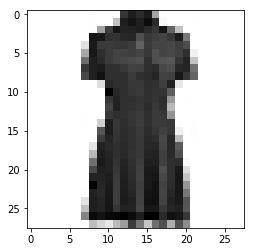

In [8]:
print("y = {label_index} ({label})".format(label_index=sample_label_1, label=label_dict[sample_label_1]))
plt.imshow(sample_1, cmap='Greys')

# Setting network parameters

Units in 1st and 2nd hidden layer.

In [9]:
n_hidden_1 = 128 
n_hidden_2 = 128

Number of shapes, classes and samples of dataset.

In [10]:
n_input = 784 
n_classes = 10 
n_samples = fashion_mnist.train.num_examples

# Creating placeholders

Create a function which will return placeholders.

In [11]:
def create_placeholders(n_x, n_y):
    X = tf.placeholder(tf.float32, [n_x, None], name="X")
    Y = tf.placeholder(tf.float32, [n_y, None], name="Y")
    return X, Y

# Initialising parameters

In [12]:
def initialize_parameters():
    
    # Set random seed for reproducibility
    tf.set_random_seed(42)
    
    # Initialize weights and biases for first hidden layer
    W1 = tf.get_variable("W1", [n_hidden_1, n_input], initializer=tf.contrib.layers.xavier_initializer(seed=42))
    b1 = tf.get_variable("b1", [n_hidden_1, 1], initializer=tf.zeros_initializer())
    
    # Initialize weights and biases for second hidden layer
    W2 = tf.get_variable("W2", [n_hidden_2, n_hidden_1], initializer=tf.contrib.layers.xavier_initializer(seed=42))
    b2 = tf.get_variable("b2", [n_hidden_2, 1], initializer=tf.zeros_initializer())
    
    # Initialize weights and biases for output layer
    W3 = tf.get_variable("W3", [n_classes, n_hidden_2], initializer=tf.contrib.layers.xavier_initializer(seed=42))
    b3 = tf.get_variable("b3", [n_classes, 1], initializer=tf.zeros_initializer())
    
    # Store initializations as a dictionary of parameters
    parameters = {
        "W1": W1,
        "b1": b1,
        "W2": W2,
        "b2": b2,
        "W3": W3,
        "b3": b3
    }
    
    return parameters

# Forward propagation

Create a function which takes in the input image X and our parameters dictionary, and returns the output from the last linear unit.

In [13]:
def forward_propagation(X, parameters):
    
    # Get parameters from dictionary
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    # Carry out forward propagation      
    Z1 = tf.add(tf.matmul(W1,X), b1)     
    A1 = tf.nn.relu(Z1)                  
    Z2 = tf.add(tf.matmul(W2,A1), b2)    
    A2 = tf.nn.relu(Z2)                  
    Z3 = tf.add(tf.matmul(W3,A2), b3)    
    
    return Z3

# Computing cost

Create a function to calculate computing cost.

In [14]:
def compute_cost(Z3, Y):
    
    # Get logits (predictions) and labels
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    # Compute cost
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    
    return cost

# Putting it all together

Create a function called model to do everything for us.

In [15]:
def model(train, test, learning_rate=0.0001, num_epochs=16, minibatch_size=32, print_cost=True, graph_filename='costs'):
    
    # Ensure that model can be rerun without overwriting tf variables
    ops.reset_default_graph()
    
    # For reproducibility
    tf.set_random_seed(42)
    seed = 42
    
    # Get input and output shapes
    (n_x, m) = train.images.T.shape
    n_y = train.labels.T.shape[0]
    
    costs = []
    
    # Create placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)
    
    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation
    Z3 = forward_propagation(X, parameters)
    
    # Cost function
    cost = compute_cost(Z3, Y)
    
    # Backpropagation (using Adam optimizer)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    # Initialize variables
    init = tf.global_variables_initializer()
    
    # Start session to compute Tensorflow graph
    with tf.Session() as sess:
        
        # Run initialization
        sess.run(init)
        
        # Training loop
        for epoch in range(num_epochs):
            
            epoch_cost = 0.
            num_minibatches = int(m / minibatch_size)
            seed = seed + 1
            
            for i in range(num_minibatches):
                
                # Get next batch of training data and labels
                minibatch_X, minibatch_Y = train.next_batch(minibatch_size)
                
                # Execute optimizer and cost function
                _, minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X.T, Y: minibatch_Y.T})
                
                # Update epoch cost
                epoch_cost += minibatch_cost / num_minibatches
                
            # Print the cost every epoch
            if print_cost == True:
                print("Cost after epoch {epoch_num}: {cost}".format(epoch_num=epoch, cost=epoch_cost))
                costs.append(epoch_cost)
        
        # Plot costs
        plt.figure(figsize=(16,5))
        plt.plot(np.squeeze(costs), color='#2A688B')
        plt.xlim(0, num_epochs-1)
        plt.ylabel("cost")
        plt.xlabel("iterations")
        plt.title("learning rate = {rate}".format(rate=learning_rate))
        plt.savefig(graph_filename, dpi=300)
        plt.show()
        
        # Save parameters
        parameters = sess.run(parameters)
        print("Parameters have been trained!")
        
        # Calculate correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))
        
        # Calculate accuracy on test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        
        print ("Train Accuracy:", accuracy.eval({X: train.images.T, Y: train.labels.T}))
        print ("Test Accuracy:", accuracy.eval({X: test.images.T, Y: test.labels.T}))
        
        return parameters

# Run the model

Cost after epoch 0: 0.5174783652125752
Cost after epoch 1: 0.3773607988955671
Cost after epoch 2: 0.33729600174324365
Cost after epoch 3: 0.31419044780318334
Cost after epoch 4: 0.29612032971989954
Cost after epoch 5: 0.27954687114167437
Cost after epoch 6: 0.2666020246268148
Cost after epoch 7: 0.25492539449363943
Cost after epoch 8: 0.2449902739620857
Cost after epoch 9: 0.23341711043413838
Cost after epoch 10: 0.22637448470922494
Cost after epoch 11: 0.21547373968184097
Cost after epoch 12: 0.21179822012478539
Cost after epoch 13: 0.20121664702686295
Cost after epoch 14: 0.19517752144277556
Cost after epoch 15: 0.1876837708840932


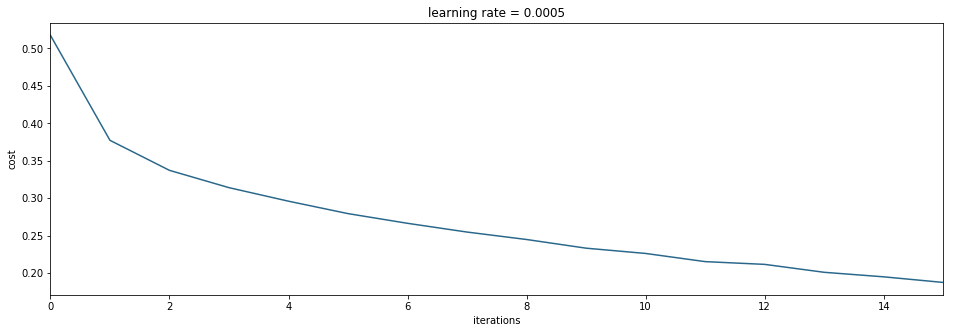

Parameters have been trained!
Train Accuracy: 0.92947274
Test Accuracy: 0.8841


In [16]:
train = fashion_mnist.train
test = fashion_mnist.test

parameters = model(train, test, learning_rate=0.0005)